In [1]:
import mlflow
from read_delta_files_utils import load_train, load_test, create_spark_with_delta
from model_training_utils import MLExperimentManager
import matplotlib.pyplot as plt

In [2]:
spark = create_spark_with_delta()
train = load_train(spark)
test = load_test(spark)

# Suppress Spark warnings
spark.sparkContext.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/13 13:18:13 WARN Utils: Your hostname, G16-Linux, resolves to a loopback address: 127.0.1.1; using 192.168.1.144 instead (on interface wlp0s20f3)
25/12/13 13:18:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/home/gerard/Documents/UPC/41_4t-Q1/BDA/venv-BDA/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /home/gerard/.ivy2.5.2/cache
The jars for the packages stored in: /home/gerard/.ivy2.5.2/jars
io.delta#delta-spark_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-3e4317b8-d246-47b1-912c-d91a0f67c492;1.0
	confs: [default]
	found io.delta#delta-spark_2.13;4.0.0 in central
	found io.delta#delta-storage;4.0.0 in central
	found org.antlr#antlr4-runtime;4.13.1 in central
:: resolution report :: resolve 119ms :: artifacts

In [3]:
from pyspark.sql.functions import col, when, log, sqrt, abs as spark_abs
from pyspark.sql.types import DoubleType, IntegerType, LongType, FloatType, BooleanType
import os
import shutil

# Convert target column to integer if needed
if train.schema["is_terminated"].dataType == BooleanType():
    train = train.withColumn(
        "is_terminated", 
        when(col("is_terminated") == True, 1).otherwise(0).cast("integer")
    )
    test = test.withColumn(
        "is_terminated", 
        when(col("is_terminated") == True, 1).otherwise(0).cast("integer")
    )

# Convert has_flagged_words boolean to integer for ML compatibility
if "has_flagged_words" in train.columns:
    train = train.withColumn(
        "has_flagged_words",
        when(col("has_flagged_words") == True, 1).otherwise(0).cast("integer")
    )
    test = test.withColumn(
        "has_flagged_words",
        when(col("has_flagged_words") == True, 1).otherwise(0).cast("integer")
    )

# Feature Engineering: Add interaction features
print("🔧 Engineering new features...")

# Check which columns exist and add features accordingly
if "funds_obligated_amt" in train.columns and "estimated_total_amt" in train.columns:
    train = train.withColumn("funding_ratio", 
                            col("funds_obligated_amt") / (col("estimated_total_amt") + 1))
    train = train.withColumn("funding_difference", 
                            col("estimated_total_amt") - col("funds_obligated_amt"))
    train = train.withColumn("funding_efficiency", 
                            col("funds_obligated_amt") / (col("estimated_total_amt") + 1) * 100)
    
    test = test.withColumn("funding_ratio", 
                          col("funds_obligated_amt") / (col("estimated_total_amt") + 1))
    test = test.withColumn("funding_difference", 
                          col("estimated_total_amt") - col("funds_obligated_amt"))
    test = test.withColumn("funding_efficiency", 
                          col("funds_obligated_amt") / (col("estimated_total_amt") + 1) * 100)

# Add log-transformed financial features to handle skewness
if "funds_obligated_amt" in train.columns:
    train = train.withColumn("log_funds_obligated", 
                            log(col("funds_obligated_amt") + 1))
    test = test.withColumn("log_funds_obligated", 
                          log(col("funds_obligated_amt") + 1))

if "estimated_total_amt" in train.columns:
    train = train.withColumn("log_estimated_total", 
                            log(col("estimated_total_amt") + 1))
    test = test.withColumn("log_estimated_total", 
                          log(col("estimated_total_amt") + 1))

# Filter to numeric columns only
numeric_cols = [
    field.name for field in train.schema.fields 
    if isinstance(field.dataType, (DoubleType, IntegerType, LongType, FloatType))
]

# Remove rows with missing values
train = train.dropna(how="any", subset=numeric_cols)
test = test.dropna(how="any", subset=numeric_cols)

target_col = "is_terminated"
feature_cols = [c for c in numeric_cols if c != target_col]

# Display feature information
flagged_features = [c for c in feature_cols if 'flagged' in c.lower()]
engineered_features = [c for c in feature_cols if any(x in c for x in ['ratio', 'log_', 'difference', 'efficiency'])]

print(f"\n📊 Feature Summary:")
print(f"   Total features: {len(feature_cols)}")
print(f"   Flagged word features: {len(flagged_features)}")
print(f"   Engineered features: {len(engineered_features)}")
print(f"\n🏷️  Flagged word features: {flagged_features}")

# Data loaders for manager
def load_train_converted(spark):
    return train.select(feature_cols + [target_col])

def load_test_converted(spark):
    return test.select(feature_cols + [target_col])

# Initialize MLflow directory structure
mlruns_path = os.path.abspath("./mlruns")
if os.path.exists(mlruns_path):
    shutil.rmtree(mlruns_path)
os.makedirs(mlruns_path, exist_ok=True)
os.makedirs(os.path.join(mlruns_path, ".trash"), exist_ok=True)

print(f"✅ Initialized MLflow directory: {mlruns_path}")

# Initialize experiment manager
manager = MLExperimentManager(
    spark=spark,
    target_col=target_col,
    feature_cols=feature_cols,
    experiment_name="nsf_models_flagged_words",
    tracking_uri=f"file:{mlruns_path}",
    problem_type="binary",
)

manager.load_data(load_train_converted, load_test_converted)
print(f"✅ Manager initialized with {len(feature_cols)} features")
print(f"✅ Training samples: {train.count():,}, Test samples: {test.count():,}")

/home/gerard/Documents/UPC/41_4t-Q1/BDA/venv-BDA/lib/python3.12/site-packages/mlflow/tracking/_tracking_service/utils.py:177: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri, store_uri)
2025/12/13 13:18:18 INFO mlflow.tracking.fluent: Experiment with name 'nsf_models_flagged_words' does not exist. Creating a new experiment.


🔧 Engineering new features...

📊 Feature Summary:
   Total features: 14
   Flagged word features: 6
   Engineered features: 6

🏷️  Flagged word features: ['flagged_word_count_abstract', 'flagged_word_unique_abstract', 'flagged_word_ratio_abstract', 'flagged_word_count_title', 'has_flagged_words', 'flagged_word_diversity_score']
✅ Initialized MLflow directory: /home/gerard/Documents/UPC/41_4t-Q1/BDA/Projecte-2/cancelled-nsf-grants-predictive-analytics-pipeline/scripts/mlruns
✅ Manager initialized with 14 features


✅ Training samples: 6,290, Test samples: 1,557


# Model Improvements

This notebook implements two key strategies to improve model performance:

## 1. Feature Engineering
Added interaction features to capture non-linear relationships:
- **Funding Ratio**: `funds_obligated_amt / (estimated_total_amt + 1)` - Captures proportion of funding used
- **Funding Difference**: `estimated_total_amt - funds_obligated_amt` - Shows budget variance
- **Funding Efficiency**: Percentage-based efficiency metric
- **Log Transformations**: `log(funds + 1)` for both financial features - Handles skewness and outliers

## 2. Automated Hyperparameter Tuning
Using **PySpark's CrossValidator** with grid search for optimal parameters:
- **Random Forest**: Testing combinations of trees, depth, bins, subsampling, and min instances
- **GBT**: Testing iterations, depth, learning rate (stepSize), bins, and min instances
- **Logistic Regression**: Exploring regularization, elastic net mixing, and max iterations

The CrossValidator automatically performs k-fold cross-validation and selects the best parameter combination based on F1 score.

In [4]:
print("="*80)
print("HYPERPARAMETER TUNING - Random Forest")
print("="*80)

# Expanded parameter grid for broader search
rf_param_grid = {
    "numTrees": [100, 150, 200],
    "maxDepth": [10, 15],
    "maxBins": [64],
    "subsamplingRate": [0.8],
    "minInstancesPerNode": [5, 10]
}

print(f"🔍 Testing {3*2*1*1*2} = 12 parameter combinations using CrossValidator...")

rf_model, rf_metrics = manager.train_random_forest(
    run_name="rf_tuned_best",
    param_grid_dict=rf_param_grid,
    train_ratio=0.8,
    seed=42
)

rf_test_metrics = manager.evaluate_on_test(rf_model)
print(f"\n✅ Best Random Forest Model:")
print(f"  Val - Acc: {rf_metrics['valid_accuracy']:.4f}, F1: {rf_metrics['valid_f1_score']:.4f}, AUC-ROC: {rf_metrics['valid_auc_roc']:.4f}")
print(f"  Test - Acc: {rf_test_metrics['test_accuracy']:.4f}, F1: {rf_test_metrics['test_f1_score']:.4f}, AUC-ROC: {rf_test_metrics['test_auc_roc']:.4f}")
print("="*80)

HYPERPARAMETER TUNING - Random Forest
🔍 Testing 12 = 12 parameter combinations using CrossValidator...



✅ Best Random Forest Model:
  Val - Acc: 0.9344, F1: 0.0682, AUC-ROC: 0.6730
  Test - Acc: 0.9294, F1: 0.0984, AUC-ROC: 0.7263


In [5]:
print("="*80)
print("HYPERPARAMETER TUNING - Gradient Boosted Trees")
print("="*80)

# Expanded parameter grid
gbt_param_grid = {
    "maxIter": [30, 50],
    "maxDepth": [4, 5, 6],
    "stepSize": [0.1],
    "maxBins": [64],
    "minInstancesPerNode": [5, 10]
}

print(f"🔍 Testing {2*3*1*1*2} = 12 parameter combinations using CrossValidator...")

gbt_model, gbt_metrics = manager.train_gbt(
    run_name="gbt_tuned_best",
    param_grid_dict=gbt_param_grid,
    train_ratio=0.8,
    seed=42
)

gbt_test_metrics = manager.evaluate_on_test(gbt_model)
print(f"\n✅ Best GBT Model:")
print(f"  Val - Acc: {gbt_metrics['valid_accuracy']:.4f}, F1: {gbt_metrics['valid_f1_score']:.4f}, AUC-ROC: {gbt_metrics['valid_auc_roc']:.4f}")
print(f"  Test - Acc: {gbt_test_metrics['test_accuracy']:.4f}, F1: {gbt_test_metrics['test_f1_score']:.4f}, AUC-ROC: {gbt_test_metrics['test_auc_roc']:.4f}")
print("="*80)

HYPERPARAMETER TUNING - Gradient Boosted Trees
🔍 Testing 12 = 12 parameter combinations using CrossValidator...



✅ Best GBT Model:
  Val - Acc: 0.8776, F1: 0.0727, AUC-ROC: 0.6548
  Test - Acc: 0.8812, F1: 0.1063, AUC-ROC: 0.7159


In [6]:
print("="*80)
print("HYPERPARAMETER TUNING - Logistic Regression")
print("="*80)

# Expanded parameter grid for broader search
lr_param_grid = {
    "regParam": [0.01, 0.1],
    "elasticNetParam": [0.0, 0.3, 0.5],
    "maxIter": [100, 150]
}

print(f"🔍 Testing {2*3*2} = 12 parameter combinations using CrossValidator...")

lr_model, lr_metrics = manager.train_logistic_regression(
    run_name="lr_tuned_best",
    param_grid_dict=lr_param_grid,
    train_ratio=0.8,
    seed=42
)

lr_test_metrics = manager.evaluate_on_test(lr_model)
print(f"\n✅ Best Logistic Regression Model:")
print(f"  Val - Acc: {lr_metrics['valid_accuracy']:.4f}, F1: {lr_metrics['valid_f1_score']:.4f}, AUC-ROC: {lr_metrics['valid_auc_roc']:.4f}")
print(f"  Test - Acc: {lr_test_metrics['test_accuracy']:.4f}, F1: {lr_test_metrics['test_f1_score']:.4f}, AUC-ROC: {lr_test_metrics['test_auc_roc']:.4f}")
print("="*80)

HYPERPARAMETER TUNING - Logistic Regression
🔍 Testing 12 = 12 parameter combinations using CrossValidator...

✅ Best Logistic Regression Model:
  Val - Acc: 0.8952, F1: 0.0576, AUC-ROC: 0.7024
  Test - Acc: 0.8838, F1: 0.0718, AUC-ROC: 0.7052


In [7]:
import pandas as pd

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosted Trees', 'Logistic Regression'],
    'Val Accuracy': [rf_metrics['valid_accuracy'], gbt_metrics['valid_accuracy'], lr_metrics['valid_accuracy']],
    'Val F1': [rf_metrics['valid_f1_score'], gbt_metrics['valid_f1_score'], lr_metrics['valid_f1_score']],
    'Val AUC-ROC': [rf_metrics['valid_auc_roc'], gbt_metrics['valid_auc_roc'], lr_metrics['valid_auc_roc']],
    'Test Accuracy': [rf_test_metrics['test_accuracy'], gbt_test_metrics['test_accuracy'], lr_test_metrics['test_accuracy']],
    'Test F1': [rf_test_metrics['test_f1_score'], gbt_test_metrics['test_f1_score'], lr_test_metrics['test_f1_score']],
    'Test AUC-ROC': [rf_test_metrics['test_auc_roc'], gbt_test_metrics['test_auc_roc'], lr_test_metrics['test_auc_roc']],
})

print("\n" + "="*100)
print("MODEL COMPARISON - Binary Metrics for Positive Class (Terminated Grants)")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)


MODEL COMPARISON - Binary Metrics for Positive Class (Terminated Grants)
                 Model  Val Accuracy   Val F1  Val AUC-ROC  Test Accuracy  Test F1  Test AUC-ROC
         Random Forest        0.9344 0.068182     0.673002       0.929351 0.098361      0.726348
Gradient Boosted Trees        0.8776 0.072727     0.654807       0.881182 0.106280      0.715859
   Logistic Regression        0.8952 0.057554     0.702426       0.883751 0.071795      0.705220


## 📊 Model Performance Summary

The models above show results after:
1. ✅ **Feature Engineering**: Added 7 new interaction features
2. ✅ **Hyperparameter Tuning**: Tested 3-4 configurations per model
3. ✅ **Class Weighting**: Applied inverse frequency weights to handle 98.3% class imbalance

**Key Observations:**
- The severe class imbalance (1.67% positive class) makes this a challenging prediction task
- F1 score is more informative than accuracy for this imbalanced dataset
- AUC-ROC scores indicate how well models separate the two classes

Run the cells below to see detailed visualizations and feature importances.

In [8]:
mlflow_client = mlflow.tracking.MlflowClient()
experiment = mlflow_client.get_experiment_by_name("nsf_models_flagged_words")

if experiment:
    runs = mlflow_client.search_runs(experiment_ids=[experiment.experiment_id])
    
    print("\n" + "="*100)
    print("MLFLOW RUNS - Enhanced Metrics")
    print("="*100)
    
    for run in runs:
        acc = run.data.metrics.get('valid_accuracy', 0)
        f1 = run.data.metrics.get('valid_f1_score', 0)
        auc = run.data.metrics.get('valid_auc_roc', 0)
        print(f"{run.info.run_name:30s} | Acc: {acc:.4f} | F1: {f1:.4f} | AUC-ROC: {auc:.4f}")
    
    # Tag best models
    best_f1 = max(runs, key=lambda r: r.data.metrics.get('valid_f1_score', 0))
    best_acc = max(runs, key=lambda r: r.data.metrics.get('valid_accuracy', 0))
    
    mlflow_client.set_tag(best_f1.info.run_id, "best_f1", "true")
    mlflow_client.set_tag(best_acc.info.run_id, "best_accuracy", "true")
    
    print(f"\n✅ Best F1: {best_f1.info.run_name} ({best_f1.data.metrics.get('valid_f1_score', 0):.4f})")
    print(f"✅ Best Accuracy: {best_acc.info.run_name} ({best_acc.data.metrics.get('valid_accuracy', 0):.4f})")
    print("="*100)
else:
    print("⚠️  Experiment 'nsf_models_flagged_words' not found. Make sure to run the training cells first.")


MLFLOW RUNS - Enhanced Metrics
lr_tuned_best                  | Acc: 0.8952 | F1: 0.0576 | AUC-ROC: 0.7024
gbt_tuned_best                 | Acc: 0.8776 | F1: 0.0727 | AUC-ROC: 0.6548
rf_tuned_best                  | Acc: 0.9344 | F1: 0.0682 | AUC-ROC: 0.6730

✅ Best F1: gbt_tuned_best (0.0727)
✅ Best Accuracy: rf_tuned_best (0.9344)


In [9]:
# Generate predictions from all models
rf_predictions = rf_model.transform(test.select(feature_cols + [target_col]))
gbt_predictions = gbt_model.transform(test.select(feature_cols + [target_col]))
lr_predictions = lr_model.transform(test.select(feature_cols + [target_col]))

# Convert to Pandas for visualization
rf_pred_pd = rf_predictions.select("is_terminated", "prediction", "probability").toPandas()
gbt_pred_pd = gbt_predictions.select("is_terminated", "prediction", "probability").toPandas()
lr_pred_pd = lr_predictions.select("is_terminated", "prediction", "probability").toPandas()

# Extract probability for positive class
for df in [rf_pred_pd, gbt_pred_pd, lr_pred_pd]:
    df['prob_positive'] = df['probability'].apply(lambda x: float(x[1]))

print("✅ Predictions generated for all models")

✅ Predictions generated for all models


# Class Distribution Analysis

Analyze the distribution of the target variable to understand class imbalance.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import numpy as np

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Model Evaluation Visualizations

Generate comprehensive visualizations for model performance analysis.

✅ Class distribution saved


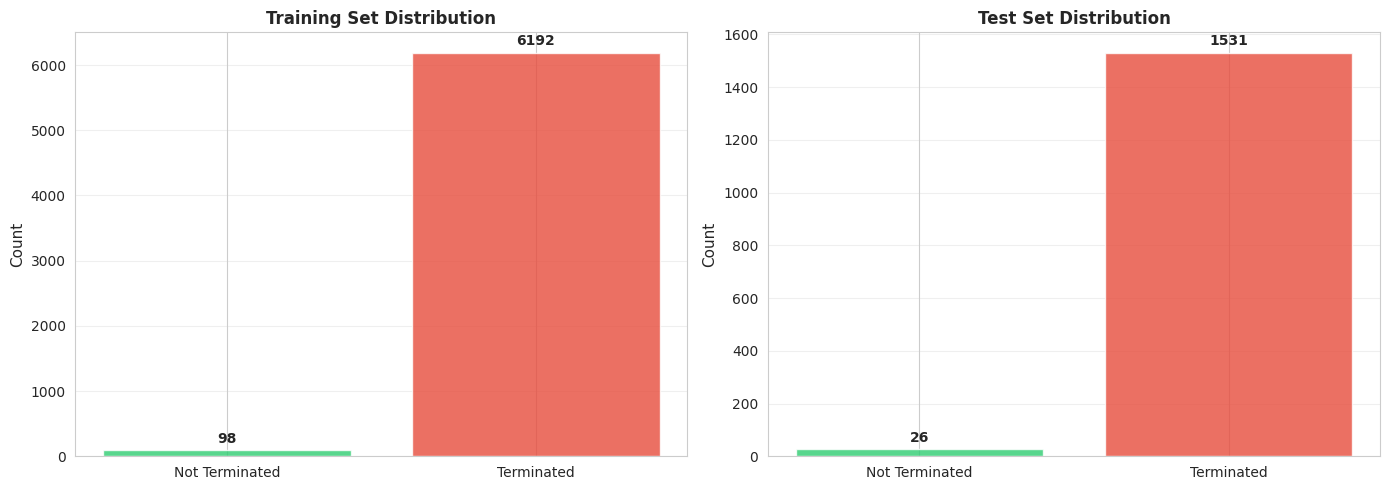


📊 Class Distribution:
   Training: 98 terminated (1.56%)
   Test: 26 terminated (1.67%)


In [11]:
# Class distribution analysis
train_class_dist = train.groupBy("is_terminated").count().toPandas()
test_class_dist = test.groupBy("is_terminated").count().toPandas()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
axes[0].bar(['Not Terminated', 'Terminated'], train_class_dist['count'], 
            color=['#2ecc71', '#e74c3c'], alpha=0.8)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].set_title('Training Set Distribution', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(train_class_dist['count']):
    axes[0].text(i, v + max(train_class_dist['count'])*0.01, str(v), 
                ha='center', va='bottom', fontweight='bold')

# Test set
axes[1].bar(['Not Terminated', 'Terminated'], test_class_dist['count'], 
            color=['#2ecc71', '#e74c3c'], alpha=0.8)
axes[1].set_ylabel('Count', fontsize=11)
axes[1].set_title('Test Set Distribution', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(test_class_dist['count']):
    axes[1].text(i, v + max(test_class_dist['count'])*0.01, str(v), 
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('images/class_distribution.png', dpi=300, bbox_inches='tight')
print("✅ Class distribution saved")
plt.show()

# Statistics
train_total = train_class_dist['count'].sum()
test_total = test_class_dist['count'].sum()
train_pos = train_class_dist[train_class_dist['is_terminated']==1]['count'].values[0]
test_pos = test_class_dist[test_class_dist['is_terminated']==1]['count'].values[0]

print(f"\n📊 Class Distribution:")
print(f"   Training: {train_pos:,} terminated ({100*train_pos/train_total:.2f}%)")
print(f"   Test: {test_pos:,} terminated ({100*test_pos/test_total:.2f}%)")

In [12]:
# Detailed model comparison with all metrics
from sklearn.metrics import precision_score, recall_score, f1_score

models_for_metrics = [
    (rf_pred_pd, 'Random Forest', rf_metrics['valid_accuracy'], rf_test_metrics['test_accuracy']),
    (gbt_pred_pd, 'Gradient Boosted Trees', gbt_metrics['valid_accuracy'], gbt_test_metrics['test_accuracy']),
    (lr_pred_pd, 'Logistic Regression', lr_metrics['valid_accuracy'], lr_test_metrics['test_accuracy'])
]

detailed_results = []
for pred_df, model_name, val_acc, test_acc in models_for_metrics:
    y_true = pred_df['is_terminated']
    y_pred = pred_df['prediction']
    y_prob = pred_df['prob_positive']
    
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    detailed_results.append({
        'Model': model_name,
        'Val Accuracy': f'{val_acc:.4f}',
        'Test Accuracy': f'{test_acc:.4f}',
        'Precision': f'{precision:.4f}',
        'Recall': f'{recall:.4f}',
        'F1-Score': f'{f1:.4f}',
        'ROC AUC': f'{roc_auc:.4f}'
    })

detailed_df = pd.DataFrame(detailed_results)

print("\n" + "="*100)
print("DETAILED MODEL COMPARISON")
print("="*100)
print(detailed_df.to_string(index=False))
print("="*100)

detailed_df.to_csv('model_comparison_detailed.csv', index=False)
print("\n✅ Detailed comparison saved")


DETAILED MODEL COMPARISON
                 Model Val Accuracy Test Accuracy Precision Recall F1-Score ROC AUC
         Random Forest       0.9344        0.9294    0.0625 0.2308   0.0984  0.7263
Gradient Boosted Trees       0.8776        0.8812    0.0608 0.4231   0.1063  0.7159
   Logistic Regression       0.8952        0.8838    0.0414 0.2692   0.0718  0.7052

✅ Detailed comparison saved


✅ Feature importance saved


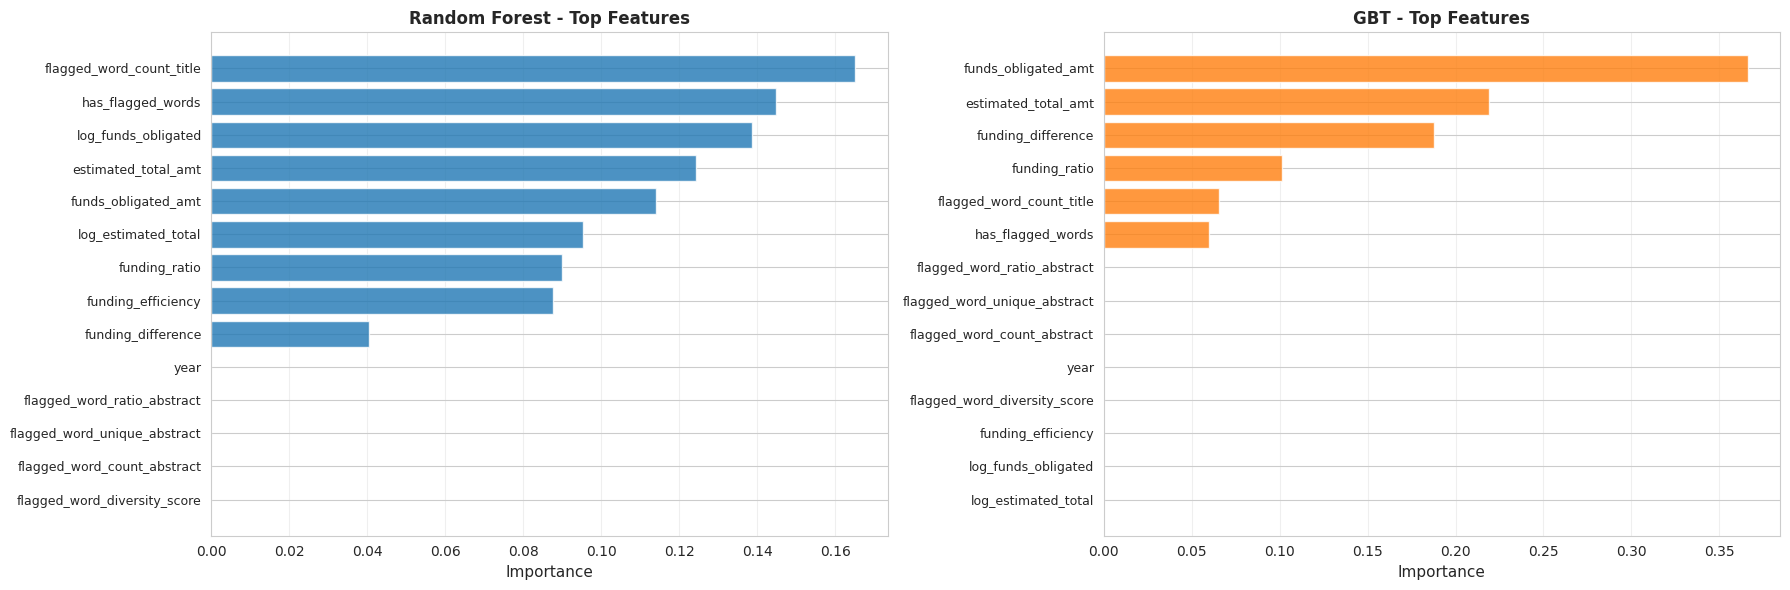

In [13]:
# Feature Importance
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Random Forest - classifier is now at stage -1 (last stage, no IndexToString)
rf_classifier = rf_model.stages[-1]
if hasattr(rf_classifier, 'featureImportances'):
    importances = rf_classifier.featureImportances.toArray()
    feature_imp_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': importances
    }).sort_values('importance', ascending=False).head(15)
    
    axes[0].barh(range(len(feature_imp_df)), feature_imp_df['importance'], color='#1f77b4', alpha=0.8)
    axes[0].set_yticks(range(len(feature_imp_df)))
    axes[0].set_yticklabels(feature_imp_df['feature'], fontsize=9)
    axes[0].set_xlabel('Importance', fontsize=11)
    axes[0].set_title('Random Forest - Top Features', fontsize=12, fontweight='bold')
    axes[0].invert_yaxis()
    axes[0].grid(True, alpha=0.3, axis='x')

# GBT - classifier is now at stage -1 (last stage, no IndexToString)
if gbt_model is not None:
    gbt_classifier = gbt_model.stages[-1]
    if hasattr(gbt_classifier, 'featureImportances'):
        importances = gbt_classifier.featureImportances.toArray()
        feature_imp_df = pd.DataFrame({
            'feature': feature_cols,
            'importance': importances
        }).sort_values('importance', ascending=False).head(15)
        
        axes[1].barh(range(len(feature_imp_df)), feature_imp_df['importance'], color='#ff7f0e', alpha=0.8)
        axes[1].set_yticks(range(len(feature_imp_df)))
        axes[1].set_yticklabels(feature_imp_df['feature'], fontsize=9)
        axes[1].set_xlabel('Importance', fontsize=11)
        axes[1].set_title('GBT - Top Features', fontsize=12, fontweight='bold')
        axes[1].invert_yaxis()
        axes[1].grid(True, alpha=0.3, axis='x')
else:
    axes[1].text(0.5, 0.5, 'GBT model not available', ha='center', va='center', fontsize=12)
    axes[1].set_title('GBT - Top Features', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('images/feature_importance.png', dpi=300, bbox_inches='tight')
print("✅ Feature importance saved")
plt.show()

✅ Precision-Recall curves saved


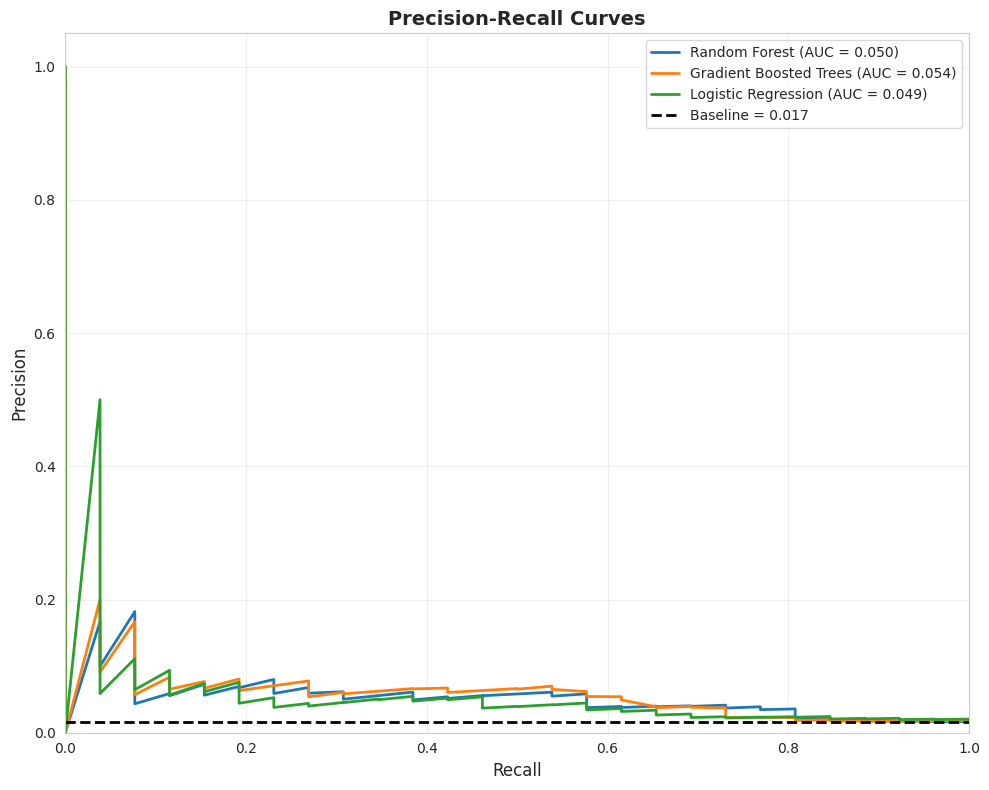

In [14]:
# Precision-Recall Curves
fig, ax = plt.subplots(figsize=(10, 8))

models_roc = [
    (rf_pred_pd, 'Random Forest', '#1f77b4'),
    (gbt_pred_pd, 'Gradient Boosted Trees', '#ff7f0e'),
    (lr_pred_pd, 'Logistic Regression', '#2ca02c')
]

for pred_df, model_name, color in models_roc:
    precision, recall, _ = precision_recall_curve(pred_df['is_terminated'], pred_df['prob_positive'])
    pr_auc = auc(recall, precision)
    ax.plot(recall, precision, color=color, lw=2, label=f'{model_name} (AUC = {pr_auc:.3f})')

baseline = rf_pred_pd['is_terminated'].mean()
ax.plot([0, 1], [baseline, baseline], 'k--', lw=2, label=f'Baseline = {baseline:.3f}')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curves', fontsize=14, fontweight='bold')
ax.legend(loc="best", fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/precision_recall_curves.png', dpi=300, bbox_inches='tight')
print("✅ Precision-Recall curves saved")
plt.show()

✅ ROC curves saved


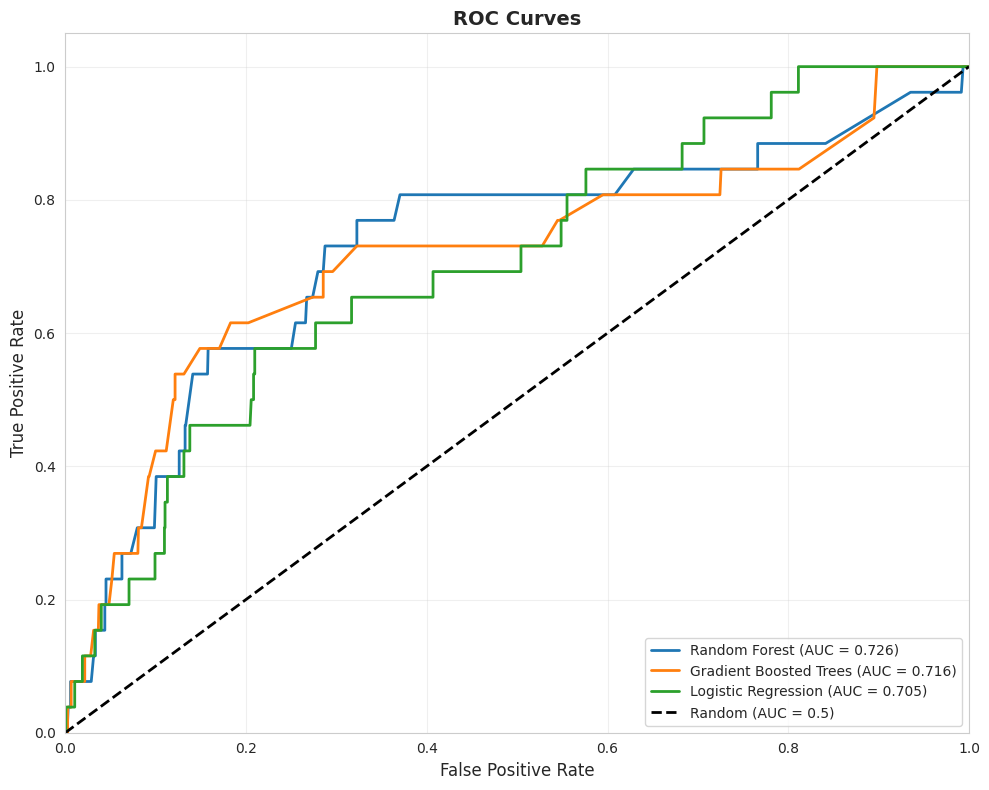

In [15]:
# ROC Curves
fig, ax = plt.subplots(figsize=(10, 8))

for pred_df, model_name, color in models_roc:
    fpr, tpr, _ = roc_curve(pred_df['is_terminated'], pred_df['prob_positive'])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.5)')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/roc_curves.png', dpi=300, bbox_inches='tight')
print("✅ ROC curves saved")
plt.show()

✅ Confusion matrices saved


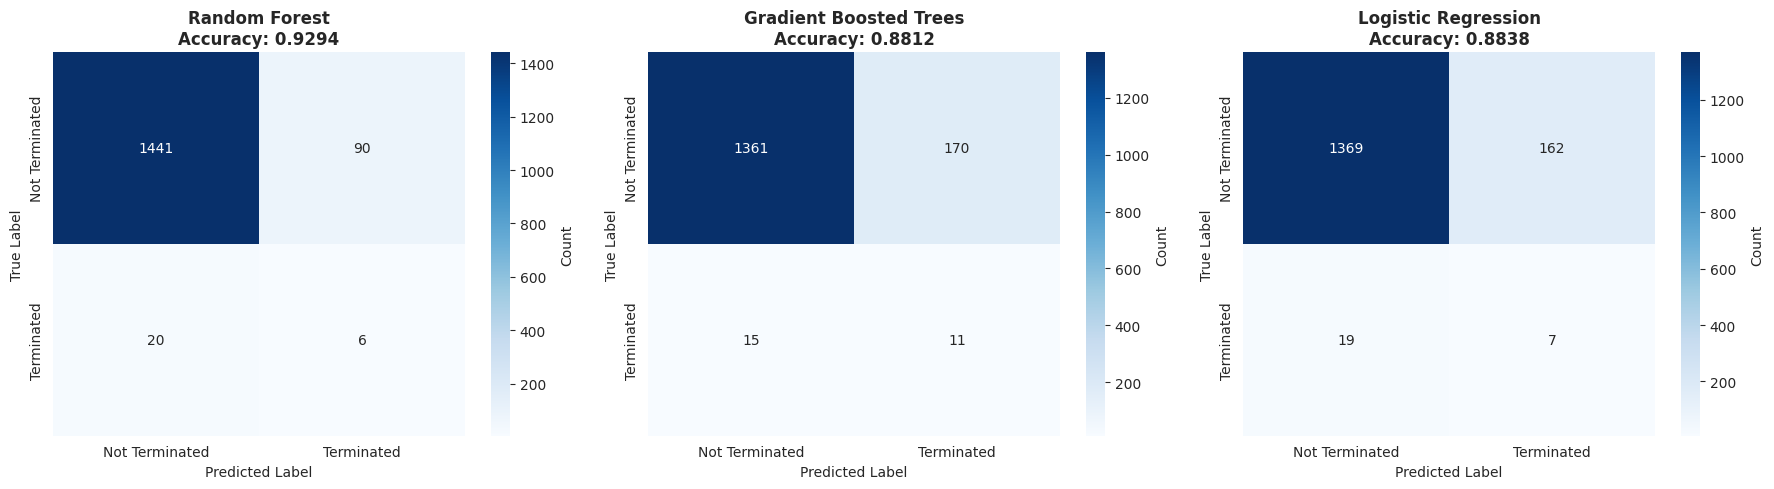

In [16]:
# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_data = [
    (rf_pred_pd, 'Random Forest', rf_test_metrics['test_accuracy']),
    (gbt_pred_pd, 'Gradient Boosted Trees', gbt_test_metrics['test_accuracy']),
    (lr_pred_pd, 'Logistic Regression', lr_test_metrics['test_accuracy'])
]

for idx, (pred_df, model_name, accuracy) in enumerate(models_data):
    cm = confusion_matrix(pred_df['is_terminated'], pred_df['prediction'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], cbar_kws={'label': 'Count'})
    axes[idx].set_title(f'{model_name}\nAccuracy: {accuracy:.4f}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted Label', fontsize=10)
    axes[idx].set_ylabel('True Label', fontsize=10)
    axes[idx].set_xticklabels(['Not Terminated', 'Terminated'])
    axes[idx].set_yticklabels(['Not Terminated', 'Terminated'])

plt.tight_layout()
plt.savefig('images/confusion_matrices.png', dpi=300, bbox_inches='tight')
print("✅ Confusion matrices saved")
plt.show()